In [12]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import datasets
import utils

In [3]:
dataset = datasets.TDSCTexture()
x, y = dataset[99]
print(x.shape, y)
print(len(dataset))

(20, 20, 3) 1
100


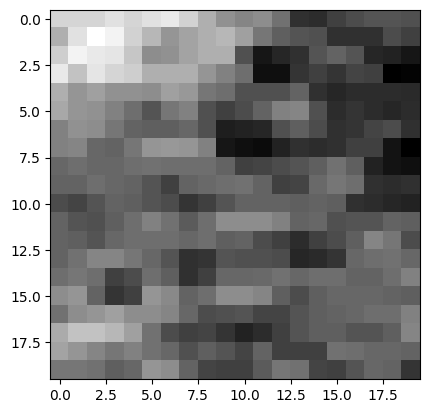

In [4]:
plt.imshow(x[:,:,0], cmap="gray")
plt.show()

In [5]:
distances = [1, 2]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm_dataset = np.zeros((100, 40), dtype=np.float32)

for idx, data in enumerate(dataset):
    x, y = data
    glcm_features = np.zeros((5,8), dtype=np.float32)
    for i in range(3):
        glcm = utils.features.glcm(x[:,:,i], distances=distances, angles=angles)
        cnt = 0
        for feature_name, value in glcm.items():
            value = value.astype(np.float32).flatten()
            glcm_features[cnt] += value
            cnt += 1
    glcm_features = glcm_features.flatten()/3
    glcm_dataset[idx] = glcm_features

print(glcm_dataset)

[[ 57.533337   131.06648     93.177185   ...   0.719143     0.5201475
    0.74693304]
 [ 16.295614    41.454296    30.669298   ...   0.6761821    0.5638431
    0.71009517]
 [ 28.630701    68.84672     47.895615   ...   0.6827176    0.53249174
    0.71816444]
 ...
 [ 11.327193    19.357342    14.441228   ...   0.8230541    0.71999127
    0.79907733]
 [ 37.574562   110.45614     78.64912    ...   0.84938115   0.7604809
    0.870869  ]
 [ 65.34649    140.68605     97.42544    ...   0.7185736    0.6126752
    0.7497123 ]]


In [19]:
features_dataset = []
s = 0
for i in range(glcm_dataset.shape[0]):
    _, y = dataset[i]
    x = np.array(glcm_dataset[i])
    features_dataset.append((x,y))
    s+=y
print(s)

42


In [7]:
class Classifier(torch.nn.Module):
    
    def __init__(self, num_input, num_hidden, num_classes) -> None:
        super(Classifier, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(num_input, num_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden, num_classes),
            torch.nn.Softmax()
        )
        
    def forward(self, x):
        return self.fc(x)

In [14]:
num_epochs = 50
learning_rate = 10e-3
device = 'cuda'
criterion = torch.nn.CrossEntropyLoss()

In [18]:
num_correct_predictions = 0
num_samples = 100

for idx in range(len(features_dataset)):
    train_data = features_dataset[:idx] + features_dataset[idx+1:]
    model = Classifier(40, 20, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    test_sample = features_dataset[idx]
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=8, shuffle=True, pin_memory=True)
    for epoch in range(num_epochs):
        for data in train_loader:
            
            x, y = data
            x = x.to(device)
            y = y.to(device).long()  
            
            predictions = model(x)
            loss = criterion(predictions, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        total = 0
        num_corrects = 0
        
    for data in train_loader:
        
        x, y = data
        x = x.to(device)
        y = y.to(device).long()  
        
        model.eval()
        
        with torch.no_grad():
        
            predictions = model(x)
            _, predictions = predictions.max(1)
            num_corrects += (predictions == y).float().sum()
            total += predictions.size(0)
        
        model.train()
        
    print(f"Testing sample #{idx}: train acc is: {num_corrects}/{total}")
                        
    x, y = test_sample
    
    x = torch.from_numpy(x).unsqueeze(0)
    y = torch.tensor(y).unsqueeze(0)
    
    x = x.to(device)
    y = y.to(device).long()  

    model.eval()

    with torch.no_grad():

        predictions = model(x)
        _, predictions = predictions.max(1)
        num_correct_predictions += (predictions == y).float().sum()
        
    model.train()  
        
print(f"Finished: test acc is: {num_correct_predictions}/{num_samples}")

Testing sample #0: train acc is: 42.0/99
Testing sample #1: train acc is: 55.0/99
Testing sample #2: train acc is: 43.0/99
Testing sample #3: train acc is: 57.0/99
Testing sample #4: train acc is: 57.0/99
Testing sample #5: train acc is: 56.0/99
Testing sample #6: train acc is: 57.0/99


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f74896e1550>
Traceback (most recent call last):
  File "/home/ozma/anaconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/ozma/anaconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Testing sample #7: train acc is: 57.0/99
Testing sample #8: train acc is: 57.0/99
Testing sample #9: train acc is: 57.0/99
Testing sample #10: train acc is: 57.0/99
Testing sample #11: train acc is: 57.0/99
Testing sample #12: train acc is: 42.0/99
Testing sample #13: train acc is: 57.0/99
Testing sample #14: train acc is: 57.0/99
Testing sample #15: train acc is: 57.0/99
Testing sample #16: train acc is: 42.0/99
Testing sample #17: train acc is: 57.0/99
Testing sample #18: train acc is: 57.0/99
Testing sample #19: train acc is: 42.0/99
Testing sample #20: train acc is: 57.0/99
Testing sample #21: train acc is: 57.0/99
Testing sample #22: train acc is: 57.0/99
Testing sample #23: train acc is: 57.0/99
Testing sample #24: train acc is: 57.0/99
Testing sample #25: train acc is: 57.0/99
Testing sample #26: train acc is: 57.0/99
Testing sample #27: train acc is: 57.0/99
Testing sample #28: train acc is: 52.0/99
Testing sample #29: train acc is: 57.0/99
Testing sample #30: train acc is: 57.